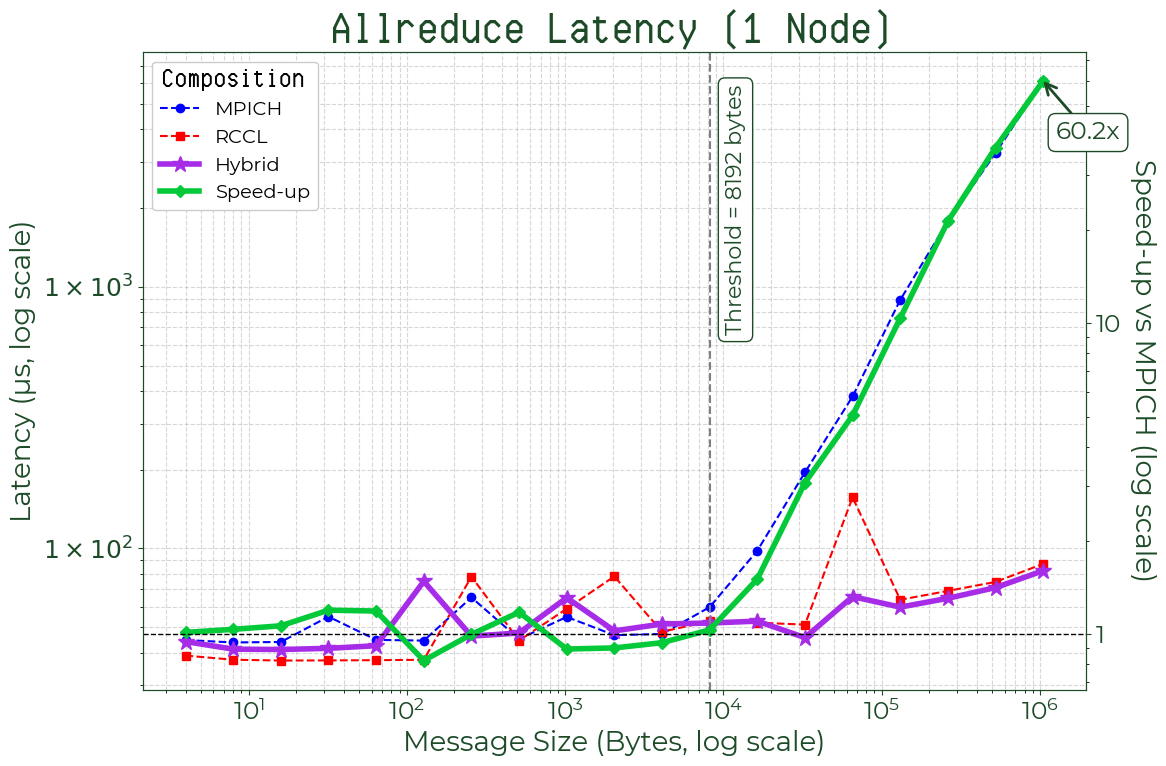

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
import matplotlib as mpl

# === Load and preprocess data ===
csv_file = "comp_single_data.csv"
plot_file = "comp_single_graph.svg"
df = pd.read_csv(csv_file)
df['size'] = pd.to_numeric(df['size'], errors='coerce')
df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
df = df.dropna(subset=['size', 'latency'])
df = df[df['latency'] > 0]
avg_df = df.groupby(['size', 'composition'])['latency'].mean().reset_index()
pivot_df = avg_df.pivot(index='size', columns='composition', values='latency')

# === Font config ===
font_path = "Montserrat Regular 400.ttf"
fm.fontManager.addfont(font_path)
custom_font = fm.FontProperties(fname='computer-says-no.ttf', size=50)
legend_title_font = fm.FontProperties(fname='computer-says-no.ttf', size=30)

mpl.rcParams.update({
    'font.family': 'Montserrat',
    'font.size': 18,
    'axes.titlesize': 26,
    'axes.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
})


# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(12, 8))
baseline = "mpi-gamma"

ax1.tick_params(axis='both', colors='#1d4b28')
ax1.spines['bottom'].set_color('#1d4b28')
ax1.spines['top'].set_color('#1d4b28')
ax1.spines['left'].set_color('#1d4b28')
ax1.spines['right'].set_color('#1d4b28')

# === Latency Curves (log-log) ===
styles = {
    "mpi-gamma": dict(color="blue", marker='o', label="MPICH", linestyle='--'),
    "rccl-beta": dict(color="red", marker='s', label="RCCL", linestyle='--'),
    "ch4-tuning": dict(color="#a62ce8", marker='*', markersize=12, label="Hybrid", linestyle='-', linewidth=4)
}

for comp, style in styles.items():
    if comp in pivot_df.columns:
        ax1.plot(pivot_df.index, pivot_df[comp], **style)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Message Size (Bytes, log scale)', color='#1d4b28')
ax1.set_ylabel('Latency (μs, log scale)', color='#1d4b28')
ax1.set_title('Allreduce Latency (1 Node)',
              fontproperties=custom_font, color="#1d4b28")

# === Vertical threshold line & shaded region ===
threshold = 8192
ax1.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)

ax1.text(
    threshold * 1.25,  # slightly to the right of the line
    ax1.get_ylim()[1] * 0.75,  # a bit above the bottom of the plot
    'Threshold = 8192 bytes',
    rotation=90,
    verticalalignment='top',
    color='#1d4b28',
    fontsize=16,
    bbox=dict(facecolor='white', edgecolor='#1d4b28', boxstyle='round,pad=0.3')
)

# === Right axis: Speed-up (Hybrid vs MPICH) ===
if baseline in pivot_df.columns and "ch4-tuning" in pivot_df.columns:
    raw_speedup = pivot_df[baseline] / pivot_df["ch4-tuning"]

    # Optional: smooth with rolling window
    speedup = raw_speedup.rolling(window=2, min_periods=1).mean()

    ax2 = ax1.twinx()
    ax2.plot(
        speedup.index, speedup,
        marker='D', color="#04c939",
        linewidth=4, label="Speed-up"
    )
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=1)

    ax2.set_yscale('log')
    ax2.set_ylabel('Speed-up vs MPICH (log scale)', fontsize=20,
                   rotation=270, labelpad=25, color='#1d4b28')
    ax2.tick_params(axis='y', color='#1d4b28')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))
    ax2.grid(False)

    # === Optional Annotation for peak speed-up ===
    max_idx = speedup.idxmax()
    ax2.annotate(f"{speedup[max_idx]:.1f}x",
             xy=(max_idx, speedup[max_idx]),
             xytext=(max_idx * 1.2, speedup[max_idx] * 0.65),  # shift left
             fontsize=18, color='#1d4b28',  # larger label
             bbox=dict(facecolor='white', edgecolor='#1d4b28', boxstyle='round,pad=0.3'),
             arrowprops=dict(
                 arrowstyle='->',
                 color='#1d4b28',
                 linewidth=2,
                 shrinkA=0, shrinkB=0,
                 mutation_scale=20  # enlarges arrow head
             ))

ax2.tick_params(axis='y', colors='#1d4b28')
ax2.spines['bottom'].set_color('#1d4b28')
ax2.spines['top'].set_color('#1d4b28')
ax2.spines['left'].set_color('#1d4b28')
ax2.spines['right'].set_color('#1d4b28')

# === Scientific formatting for y-axis ===
def sci_notation(x, _):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(x)))
    base = x / 10**exponent
    return rf"${int(base)} \times 10^{{{exponent}}}$"

ax1.yaxis.set_major_formatter(FuncFormatter(sci_notation))
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# === Unified legend (left + right) ===
handles1, labels1 = ax1.get_legend_handles_labels()
if 'ax2' in locals():
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles1 += handles2
    labels1 += labels2

ax1.legend(
    handles1, labels1,
    title="Composition",
    title_fontproperties=legend_title_font,
    facecolor="white", framealpha=1
)

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
if 'ax2' in locals():
    ax2.set_facecolor('white')

plt.tight_layout()
plt.savefig(plot_file, facecolor='white')

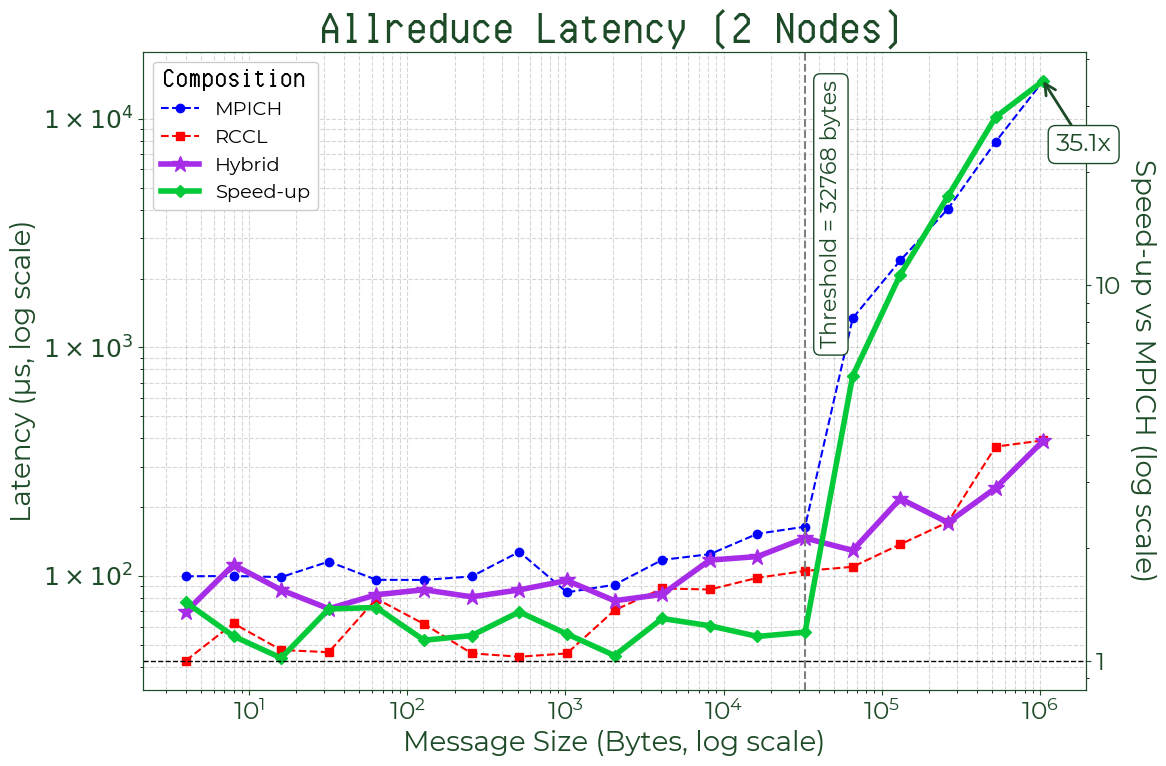

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
import matplotlib as mpl

# === Load and preprocess data ===
csv_file = "comp_multi_data.csv"
plot_file = "comp_multi_graph.svg"
df = pd.read_csv(csv_file)
df['size'] = pd.to_numeric(df['size'], errors='coerce')
df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
df = df.dropna(subset=['size', 'latency'])
df = df[df['latency'] > 0]
avg_df = df.groupby(['size', 'composition'])['latency'].mean().reset_index()
pivot_df = avg_df.pivot(index='size', columns='composition', values='latency')

# === Font config ===
font_path = "Montserrat Regular 400.ttf"
fm.fontManager.addfont(font_path)
custom_font = fm.FontProperties(fname='computer-says-no.ttf', size=50)
legend_title_font = fm.FontProperties(fname='computer-says-no.ttf', size=30)

mpl.rcParams.update({
    'font.family': 'Montserrat',
    'font.size': 18,
    'axes.titlesize': 26,
    'axes.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
})


# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(12, 8))
baseline = "mpi-alpha"

ax1.tick_params(axis='both', colors='#1d4b28')
ax1.spines['bottom'].set_color('#1d4b28')
ax1.spines['top'].set_color('#1d4b28')
ax1.spines['left'].set_color('#1d4b28')
ax1.spines['right'].set_color('#1d4b28')

# === Latency Curves (log-log) ===
styles = {
    "mpi-alpha": dict(color="blue", marker='o', label="MPICH", linestyle='--'),
    "rccl-beta": dict(color="red", marker='s', label="RCCL", linestyle='--'),
    "ch4-tuning": dict(color="#a62ce8", marker='*', markersize=12, label="Hybrid", linestyle='-', linewidth=4)
}

for comp, style in styles.items():
    if comp in pivot_df.columns:
        ax1.plot(pivot_df.index, pivot_df[comp], **style)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Message Size (Bytes, log scale)', color='#1d4b28')
ax1.set_ylabel('Latency (μs, log scale)', color='#1d4b28')
ax1.set_title('Allreduce Latency (2 Nodes)',
              fontproperties=custom_font, color="#1d4b28")

# === Vertical threshold line & shaded region ===
threshold = 32768
ax1.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)

ax1.text(
    threshold * 1.25,  # slightly to the right of the line
    ax1.get_ylim()[1] * 0.75,  # a bit above the bottom of the plot
    'Threshold = 32768 bytes',
    rotation=90,
    verticalalignment='top',
    color='#1d4b28',
    fontsize=16,
    bbox=dict(facecolor='white', edgecolor='#1d4b28', boxstyle='round,pad=0.3')
)

# === Right axis: Speed-up (Hybrid vs MPICH) ===
if baseline in pivot_df.columns and "ch4-tuning" in pivot_df.columns:
    raw_speedup = pivot_df[baseline] / pivot_df["ch4-tuning"]

    # Optional: smooth with rolling window
    speedup = raw_speedup.rolling(window=2, min_periods=1).mean()

    ax2 = ax1.twinx()
    ax2.plot(
        speedup.index, speedup,
        marker='D', color="#04c939",
        linewidth=4, label="Speed-up"
    )
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=1)

    ax2.set_yscale('log')
    ax2.set_ylabel('Speed-up vs MPICH (log scale)', fontsize=20,
                   rotation=270, labelpad=25, color='#1d4b28')
    ax2.tick_params(axis='y', color='#1d4b28')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))
    ax2.grid(False)

    # === Optional Annotation for peak speed-up ===
    max_idx = speedup.idxmax()
    ax2.annotate(f"{speedup[max_idx]:.1f}x",
             xy=(max_idx, speedup[max_idx]),
             xytext=(max_idx * 1.2, speedup[max_idx] * 0.65),  # shift left
             fontsize=18, color='#1d4b28',  # larger label
             bbox=dict(facecolor='white', edgecolor='#1d4b28', boxstyle='round,pad=0.3'),
             arrowprops=dict(
                 arrowstyle='->',
                 color='#1d4b28',
                 linewidth=2,
                 shrinkA=0, shrinkB=0,
                 mutation_scale=20  # enlarges arrow head
             ))

ax2.tick_params(axis='y', colors='#1d4b28')
ax2.spines['bottom'].set_color('#1d4b28')
ax2.spines['top'].set_color('#1d4b28')
ax2.spines['left'].set_color('#1d4b28')
ax2.spines['right'].set_color('#1d4b28')

# === Scientific formatting for y-axis ===
def sci_notation(x, _):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(x)))
    base = x / 10**exponent
    return rf"${int(base)} \times 10^{{{exponent}}}$"

ax1.yaxis.set_major_formatter(FuncFormatter(sci_notation))
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# === Unified legend (left + right) ===
handles1, labels1 = ax1.get_legend_handles_labels()
if 'ax2' in locals():
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles1 += handles2
    labels1 += labels2

ax1.legend(
    handles1, labels1,
    title="Composition",
    title_fontproperties=legend_title_font,
    facecolor="white", framealpha=1
)

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
if 'ax2' in locals():
    ax2.set_facecolor('white')

plt.tight_layout()
plt.savefig(plot_file, facecolor='white')

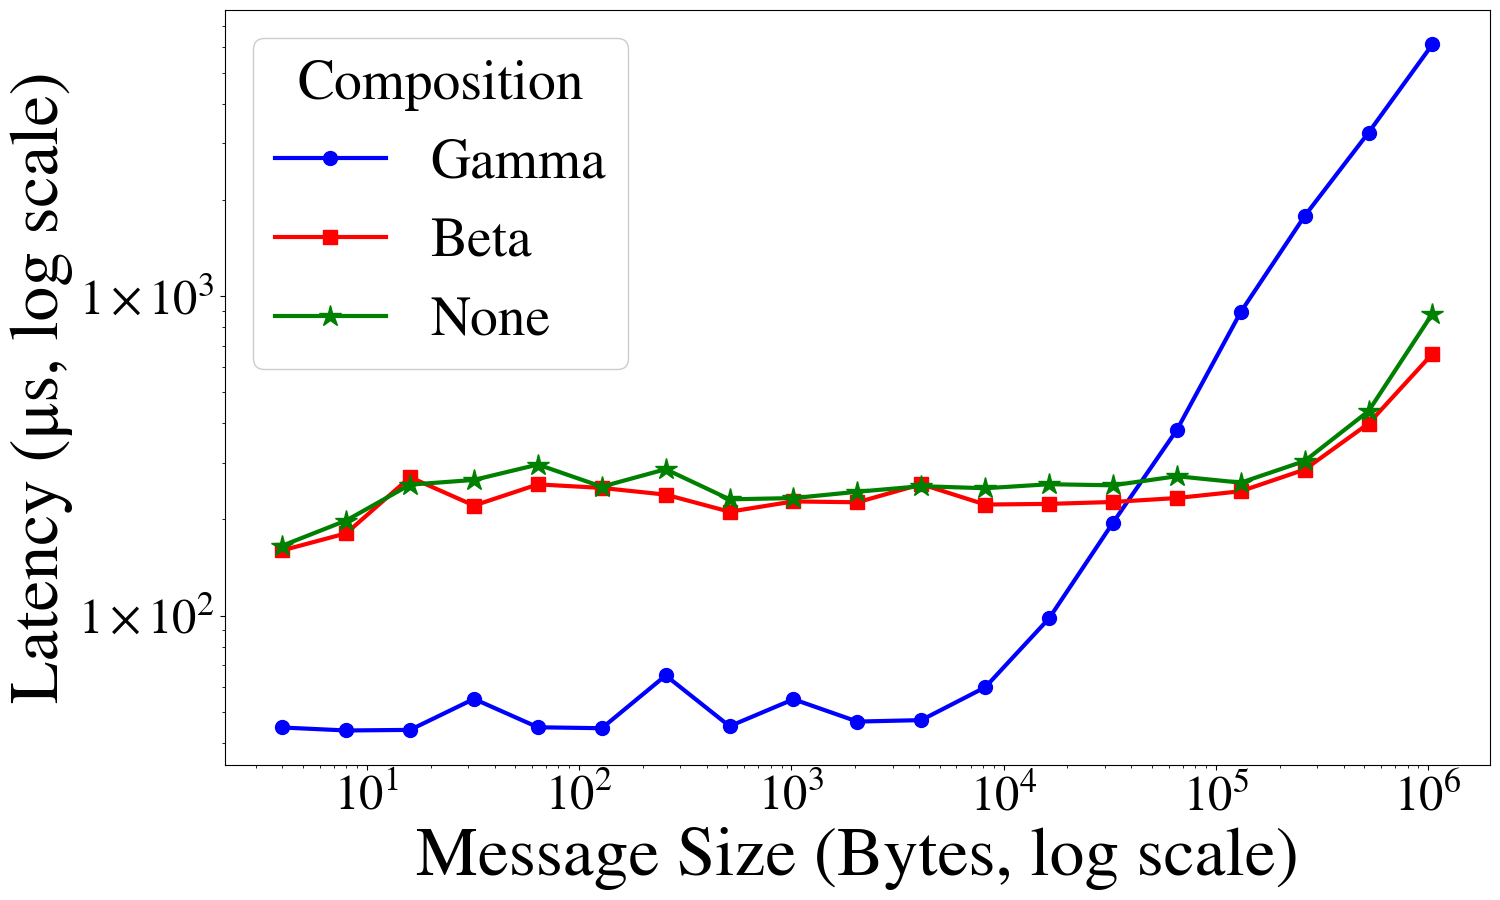

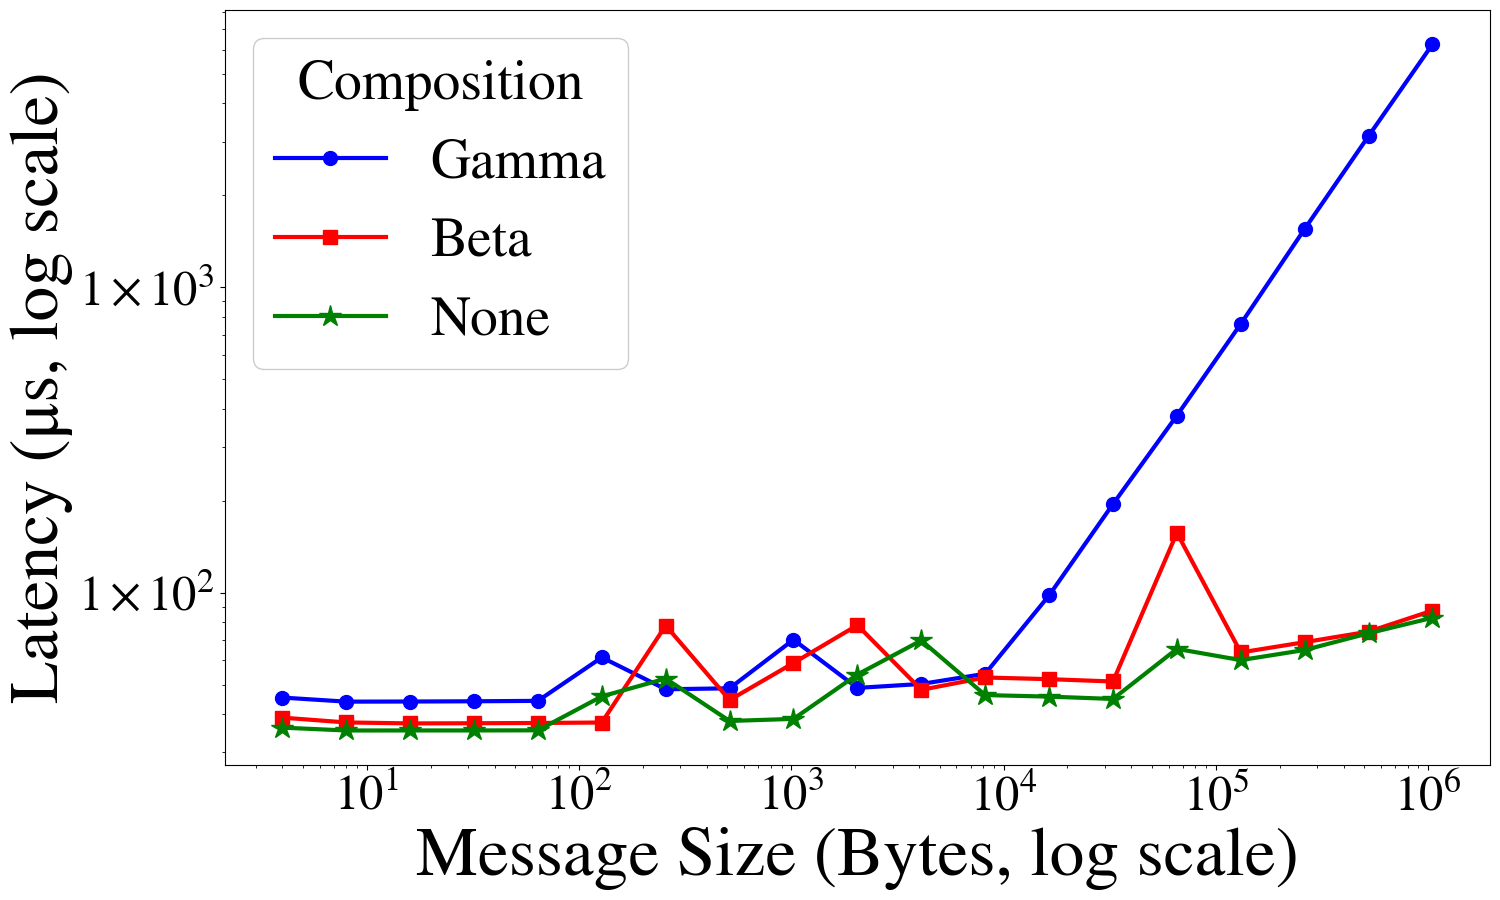

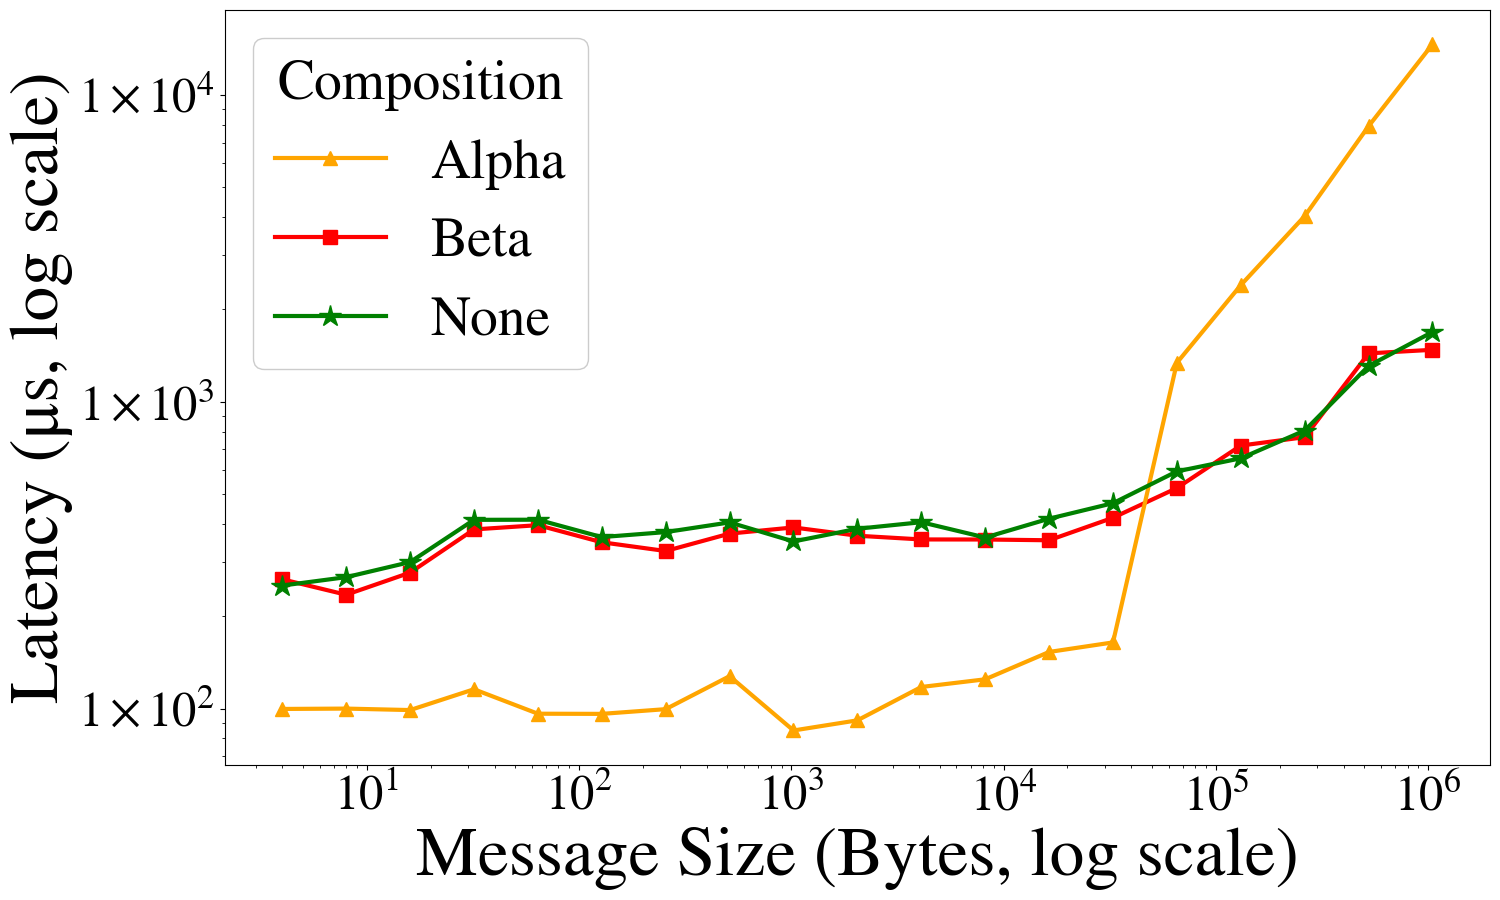

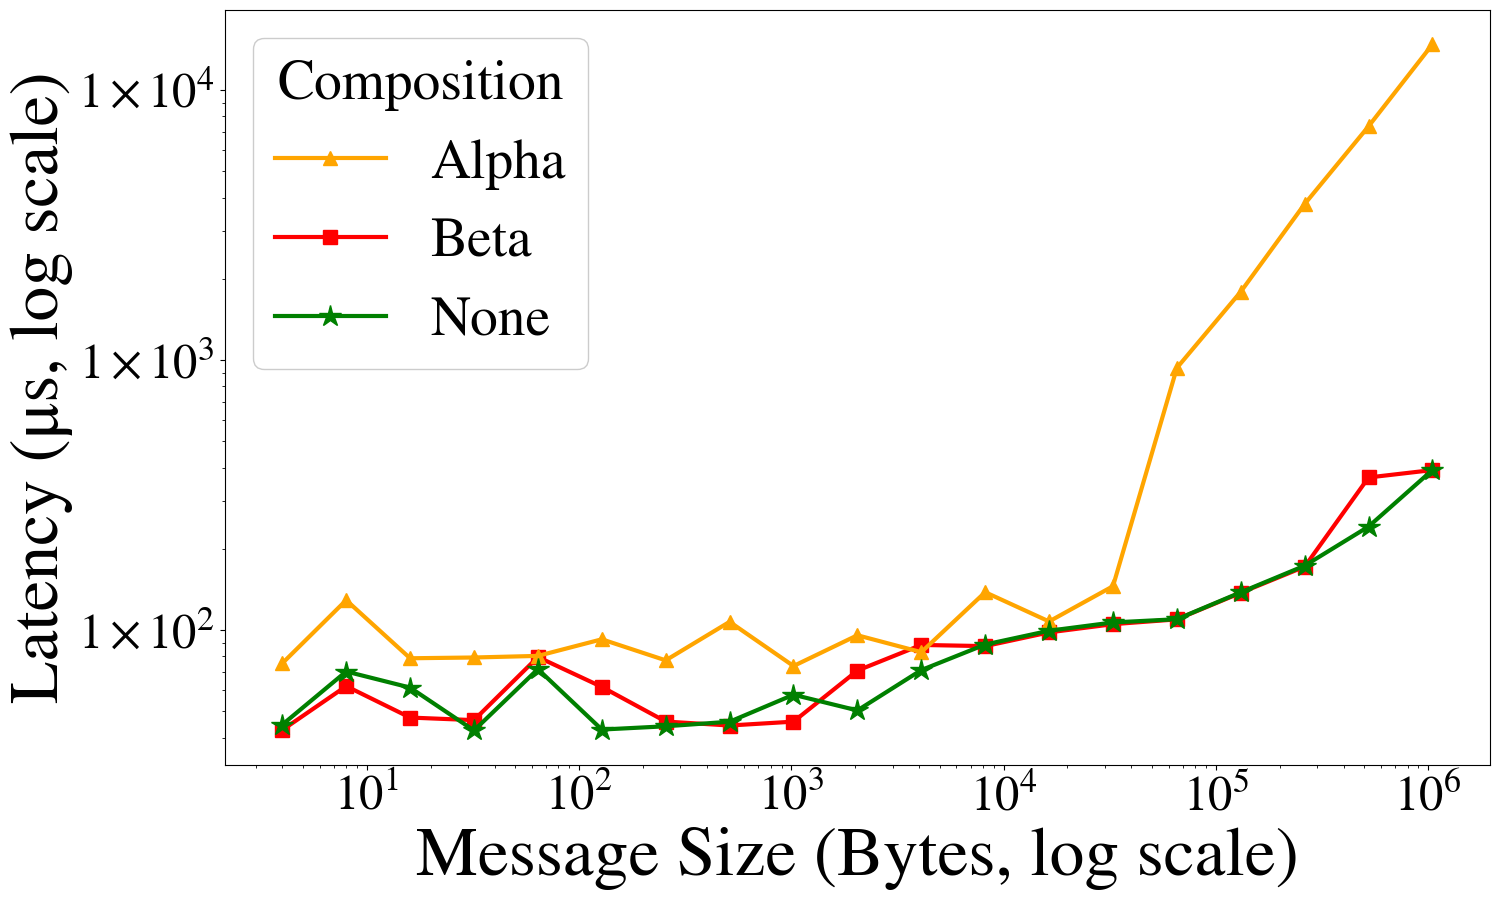

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

# === Global Matplotlib settings ===
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams.update({
    'font.size': 40,
    'axes.titlesize': 50,
    'axes.labelsize': 50,
    'legend.fontsize': 40,
    'xtick.labelsize': 35,
    'ytick.labelsize': 35,
})

# === Formatter for y-axis ===
def sci_notation(x, _):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(x)))
    base = x / 10**exponent
    return rf"${int(base)} \times 10^{{{exponent}}}$"

# === Plotting function ===
def plot_latency(csv_file, backend, nodes, output_file):
    df = pd.read_csv(csv_file)
    df['size'] = pd.to_numeric(df['size'], errors='coerce')
    df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
    df = df.dropna(subset=['size', 'latency'])
    df = df[df['latency'] > 0]

    # Filter by prefix
    prefix = f"{backend}-"
    df = df[df['composition'].str.startswith(prefix)]
    df['composition'] = df['composition'].str.replace(prefix, '', regex=False)

    # Aggregate
    avg_df = df.groupby(['size', 'composition'])['latency'].mean().reset_index()
    pivot_df = avg_df.pivot(index='size', columns='composition', values='latency')

    # === Plot setup ===
    fig, ax = plt.subplots(figsize=(16, 10))

    # Style map
    styles = {
        "gamma": dict(color="blue", marker='o', label="Gamma", linestyle='-', linewidth=3, markersize=10),
        "beta": dict(color="red", marker='s', label="Beta", linestyle='-', linewidth=3, markersize=10),
        "alpha": dict(color="orange", marker='^', label="Alpha", linestyle='-', linewidth=3, markersize=10),
        "dc-none": dict(color="green", marker='*', label="None", linestyle='-', linewidth=3, markersize=16),
    }

    for comp, style in styles.items():
        if comp in pivot_df.columns:
            ax.plot(pivot_df.index, pivot_df[comp], **style)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Message Size (Bytes, log scale)')
    ax.set_ylabel('Latency (μs, log scale)')
    title_backend = backend.upper()
    ax.yaxis.set_major_formatter(FuncFormatter(sci_notation))
    ax.grid(False)

    desired_order = ["Alpha", "Gamma", "Beta", "None"]
    legend_entries = {
        line.get_label(): line for line in ax.get_lines()
    }
    ordered_handles = [legend_entries[label] for label in desired_order if label in legend_entries]
    ordered_labels = [handle.get_label() for handle in ordered_handles]

    ax.legend(
        ordered_handles,
        ordered_labels,
        title="Composition",
        facecolor="white",
        framealpha=1,
        loc='upper left',
        title_fontsize=40
    )

    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_file, facecolor='white')
    plt.show()
    plt.close()

# === Generate all 4 plots ===
plot_latency("comp_single_data.csv", "mpi",  "1 Node", "comp_mpich_1.svg")
plot_latency("comp_single_data.csv", "rccl", "1 Node", "comp_rccl_1.svg")
plot_latency("comp_multi_data.csv",  "mpi",  "2 Nodes", "comp_mpich_2.svg")
plot_latency("comp_multi_data.csv",  "rccl", "2 Nodes", "comp_rccl_2.svg")

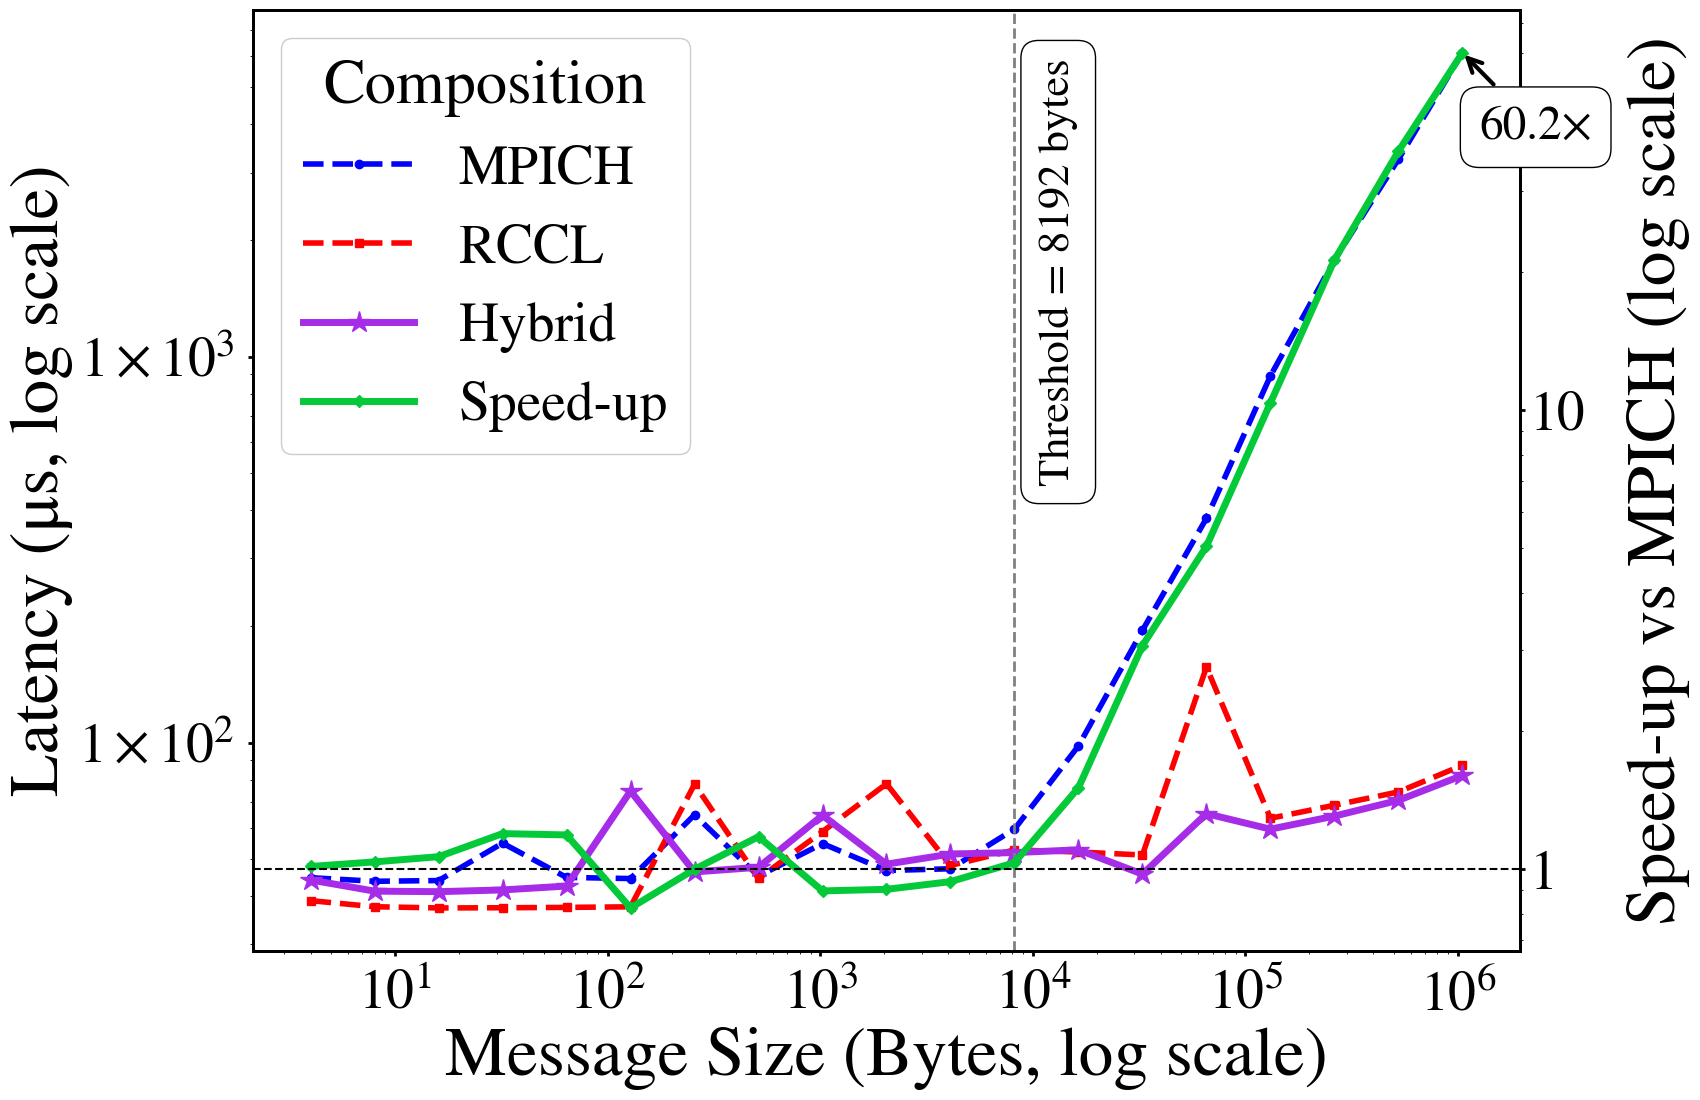

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
import matplotlib as mpl

# === Global font config: STIX for everything ===
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams.update({
    'font.size': 40,
    'axes.titlesize': 50,
    'axes.labelsize': 50,
    'legend.fontsize': 40,
    'legend.title_fontsize': 45,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40,
})

# === Load and preprocess data ===
csv_file = "comp_single_data.csv"
plot_file = "single.svg"
df = pd.read_csv(csv_file)
df['size'] = pd.to_numeric(df['size'], errors='coerce')
df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
df = df.dropna(subset=['size', 'latency'])
df = df[df['latency'] > 0]
avg_df = df.groupby(['size', 'composition'])['latency'].mean().reset_index()
pivot_df = avg_df.pivot(index='size', columns='composition', values='latency')

# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(18, 12))
baseline = "mpi-gamma"

# Set spine and tick colors
ax1.tick_params(axis='both', colors='black', width=2, pad=10)
for spine in ax1.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# === Latency Curves (log-log) ===
styles = {
    "mpi-gamma": dict(color="blue", marker='o', label="MPICH", linestyle='--', linewidth=4),
    "rccl-beta": dict(color="red", marker='s', label="RCCL", linestyle='--', linewidth=4),
    "ch4-tuning": dict(color="#a62ce8", marker='*', markersize=16, label="Hybrid", linestyle='-', linewidth=5)
}

for comp, style in styles.items():
    if comp in pivot_df.columns:
        ax1.plot(pivot_df.index, pivot_df[comp], **style)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Message Size (Bytes, log scale)', color='black')
ax1.set_ylabel('Latency (μs, log scale)', color='black')

# === Threshold line & label ===
threshold = 8192
ax1.axvline(x=threshold, color='gray', linestyle='--', linewidth=2)

ax1.text(
    threshold * 1.3,
    ax1.get_ylim()[1] * 0.75,
    'Threshold = 8192 bytes',
    rotation=90,
    verticalalignment='top',
    color='black',
    fontsize=32,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4')
)

# === Right axis: Speed-up (Hybrid vs MPICH) ===
if baseline in pivot_df.columns and "ch4-tuning" in pivot_df.columns:
    raw_speedup = pivot_df[baseline] / pivot_df["ch4-tuning"]
    speedup = raw_speedup.rolling(window=2, min_periods=1).mean()

    ax2 = ax1.twinx()
    ax2.plot(
        speedup.index, speedup,
        marker='D', color="#04c939",
        linewidth=5, label="Speed-up"
    )
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=1.5)
    ax2.set_yscale('log')
    ax2.set_ylabel('Speed-up vs MPICH (log scale)', labelpad=30, color='black')
    ax2.tick_params(axis='y', colors='black', width=2)
    for spine in ax2.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))
    ax2.grid(False)

    # === Optional peak annotation ===
    max_idx = speedup.idxmax()
    ax2.annotate(f"{speedup[max_idx]:.1f}×",
                 xy=(max_idx, speedup[max_idx]),
                 xytext=(max_idx * 1.2, speedup[max_idx] * 0.65),
                 fontsize=34, color='black',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
                 arrowprops=dict(arrowstyle='->', color='black',
                                 linewidth=3, mutation_scale=25))

# === Scientific y-axis format for latency ===
def sci_notation(x, _):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(x)))
    base = x / 10**exponent
    return rf"${int(base)} \times 10^{{{exponent}}}$"

ax1.yaxis.set_major_formatter(FuncFormatter(sci_notation))

# === Legend ===
handles1, labels1 = ax1.get_legend_handles_labels()
if 'ax2' in locals():
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles1 += handles2
    labels1 += labels2

ax1.legend(
    handles1, labels1,
    title="Composition",
    loc='upper left',
    facecolor="white", framealpha=1
)

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
if 'ax2' in locals():
    ax2.set_facecolor('white')

plt.tight_layout()
plt.savefig(plot_file, facecolor='white')

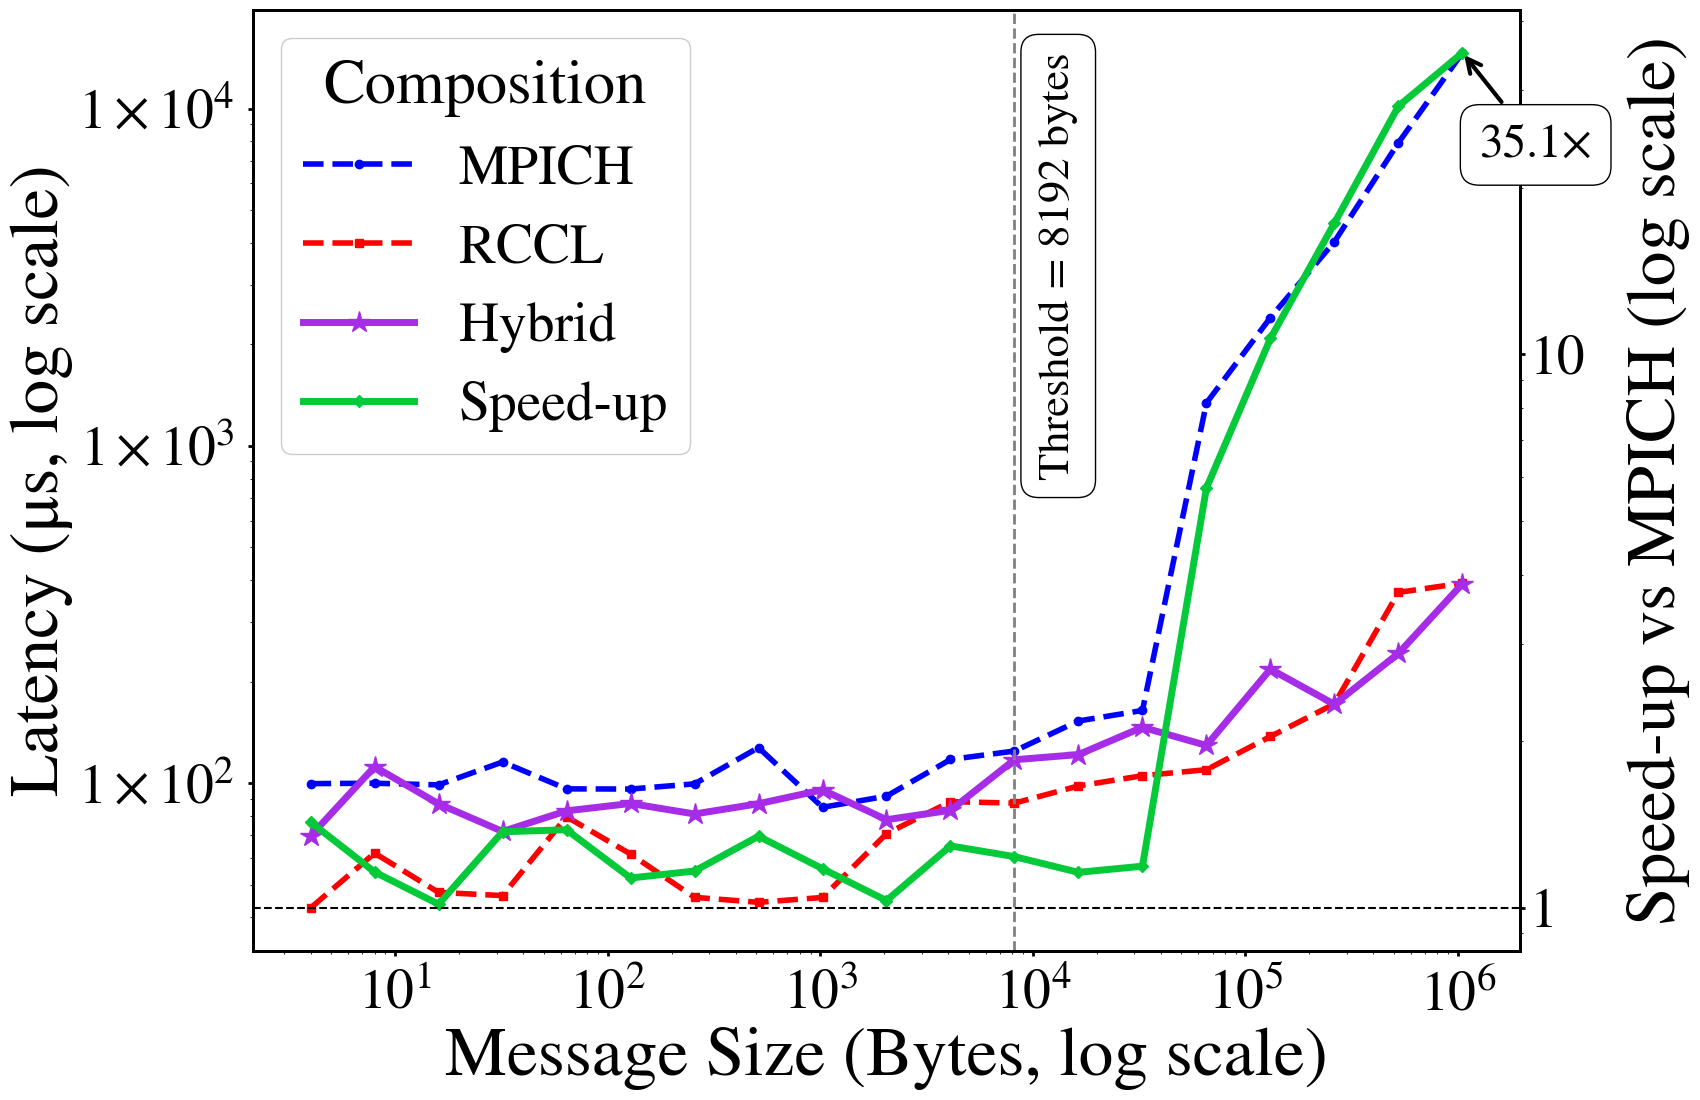

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
import matplotlib as mpl

# === Global font config: STIX for everything ===
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams.update({
    'font.size': 40,
    'axes.titlesize': 50,
    'axes.labelsize': 50,
    'legend.fontsize': 40,
    'legend.title_fontsize': 45,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40,
})

# === Load and preprocess data ===
csv_file = "comp_multi_data.csv"
plot_file = "multi.svg"
df = pd.read_csv(csv_file)
df['size'] = pd.to_numeric(df['size'], errors='coerce')
df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
df = df.dropna(subset=['size', 'latency'])
df = df[df['latency'] > 0]
avg_df = df.groupby(['size', 'composition'])['latency'].mean().reset_index()
pivot_df = avg_df.pivot(index='size', columns='composition', values='latency')

# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(18, 12))
baseline = "mpi-alpha"

# Set spine and tick colors
ax1.tick_params(axis='both', colors='black', width=2, pad=10)
for spine in ax1.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# === Latency Curves (log-log) ===
styles = {
    "mpi-alpha": dict(color="blue", marker='o', label="MPICH", linestyle='--', linewidth=4),
    "rccl-beta": dict(color="red", marker='s', label="RCCL", linestyle='--', linewidth=4),
    "ch4-tuning": dict(color="#a62ce8", marker='*', markersize=16, label="Hybrid", linestyle='-', linewidth=5)
}

for comp, style in styles.items():
    if comp in pivot_df.columns:
        ax1.plot(pivot_df.index, pivot_df[comp], **style)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Message Size (Bytes, log scale)', color='black')
ax1.set_ylabel('Latency (μs, log scale)', color='black')

# === Threshold line & label ===
threshold = 8192
ax1.axvline(x=threshold, color='gray', linestyle='--', linewidth=2)

ax1.text(
    threshold * 1.3,
    ax1.get_ylim()[1] * 0.75,
    'Threshold = 8192 bytes',
    rotation=90,
    verticalalignment='top',
    color='black',
    fontsize=32,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4')
)

# === Right axis: Speed-up (Hybrid vs MPICH) ===
if baseline in pivot_df.columns and "ch4-tuning" in pivot_df.columns:
    raw_speedup = pivot_df[baseline] / pivot_df["ch4-tuning"]
    speedup = raw_speedup.rolling(window=2, min_periods=1).mean()

    ax2 = ax1.twinx()
    ax2.plot(
        speedup.index, speedup,
        marker='D', color="#04c939",
        linewidth=5, label="Speed-up"
    )
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=1.5)
    ax2.set_yscale('log')
    ax2.set_ylabel('Speed-up vs MPICH (log scale)', labelpad=30, color='black')
    ax2.tick_params(axis='y', colors='black', width=2)
    for spine in ax2.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))
    ax2.grid(False)

    # === Optional peak annotation ===
    max_idx = speedup.idxmax()
    ax2.annotate(f"{speedup[max_idx]:.1f}×",
                 xy=(max_idx, speedup[max_idx]),
                 xytext=(max_idx * 1.2, speedup[max_idx] * 0.65),
                 fontsize=34, color='black',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
                 arrowprops=dict(arrowstyle='->', color='black',
                                 linewidth=3, mutation_scale=25))

# === Scientific y-axis format for latency ===
def sci_notation(x, _):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(x)))
    base = x / 10**exponent
    return rf"${int(base)} \times 10^{{{exponent}}}$"

ax1.yaxis.set_major_formatter(FuncFormatter(sci_notation))

# === Legend ===
handles1, labels1 = ax1.get_legend_handles_labels()
if 'ax2' in locals():
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles1 += handles2
    labels1 += labels2

ax1.legend(
    handles1, labels1,
    title="Composition",
    loc='upper left',
    facecolor="white", framealpha=1
)

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
if 'ax2' in locals():
    ax2.set_facecolor('white')

plt.tight_layout()
plt.savefig(plot_file, facecolor='white')

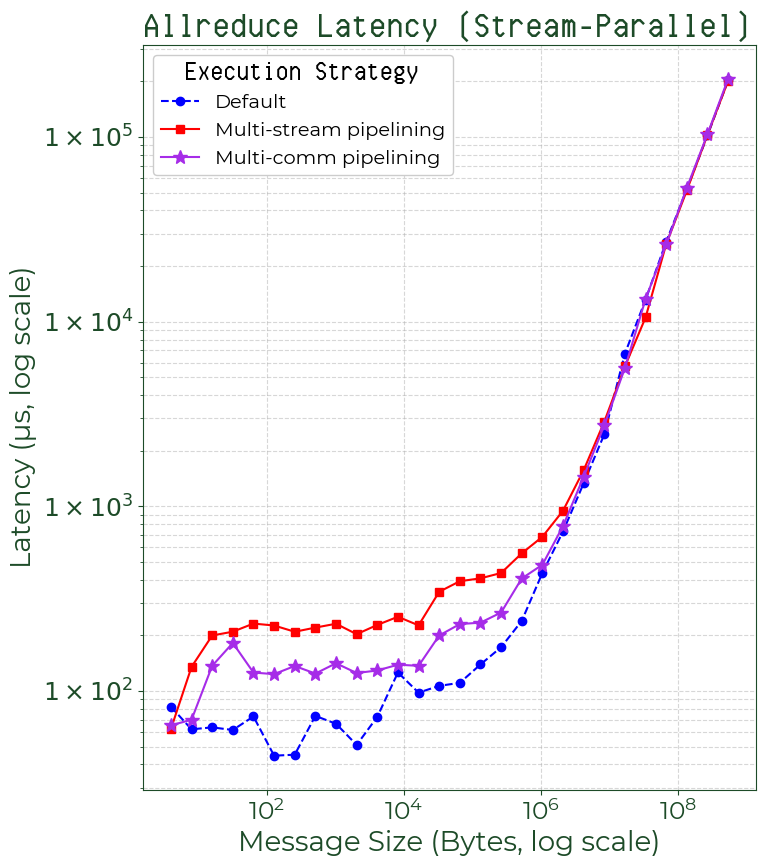

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
import matplotlib as mpl

# === Font config ===
font_path = "Montserrat Regular 400.ttf"
fm.fontManager.addfont(font_path)
custom_font = fm.FontProperties(fname='computer-says-no.ttf', size=40)
legend_title_font = fm.FontProperties(fname='computer-says-no.ttf', size=30)

mpl.rcParams.update({
    'font.family': 'Montserrat',
    'font.size': 18,
    'axes.titlesize': 26,
    'axes.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'ytick.color': '1d4b28'
})

# === Read and process CSV files ===
def load_data(filename, label):
    df = pd.read_csv(filename)
    df['size'] = pd.to_numeric(df['size'], errors='coerce')
    df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
    df = df.dropna(subset=['size', 'latency'])
    df = df[df['latency'] > 0]
    avg_df = df.groupby('size')['latency'].mean().reset_index()
    avg_df['composition'] = label
    return avg_df

df1 = load_data("og_beta.csv", "Default")
df2 = load_data("1comm4stream.csv", "1 Comm, 4 Streams")
df3 = load_data("4comm4stream.csv", "4 Comms, 4 Streams")

all_df = pd.concat([df1, df2, df3])
pivot_df = all_df.pivot(index='size', columns='composition', values='latency')

# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(8, 9))
baseline = "Default"

ax1.tick_params(axis='both', colors='#1d4b28')
for spine in ax1.spines.values():
    spine.set_color('#1d4b28')

styles = {
    "Default": dict(color="blue", marker='o', label="Default", linestyle='--'),
    "1 Comm, 4 Streams": dict(color="red", marker='s', label="Multi-stream pipelining", linestyle='-'),
    "4 Comms, 4 Streams": dict(color="#a62ce8", marker='*', markersize=10, label="Multi-comm pipelining", linestyle='-'),
}

for comp, style in styles.items():
    if comp in pivot_df.columns:
        ax1.plot(pivot_df.index, pivot_df[comp], **style)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Message Size (Bytes, log scale)', color='#1d4b28')
ax1.set_ylabel('Latency (μs, log scale)', color='#1d4b28')
ax1.set_title('Allreduce Latency (Stream-Parallel)',
              fontproperties=custom_font, color="#1d4b28")

# === Speed-up plot ===
# === Format y-axis ===
def sci_notation(x, _):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(x)))
    base = x / 10**exponent
    return rf"${int(base)} \times 10^{{{exponent}}}$"

ax1.yaxis.set_major_formatter(FuncFormatter(sci_notation))

for label in ax1.get_yticklabels():
  label.set_color('#1d4b28')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# === Unified legend ===
handles1, labels1 = ax1.get_legend_handles_labels()

ax1.legend(handles1, labels1,
           title="Execution Strategy",
           title_fontproperties=legend_title_font,
           facecolor="white", framealpha=1)

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

plt.tight_layout()
plt.savefig("chunked_comparison.png", facecolor='white')

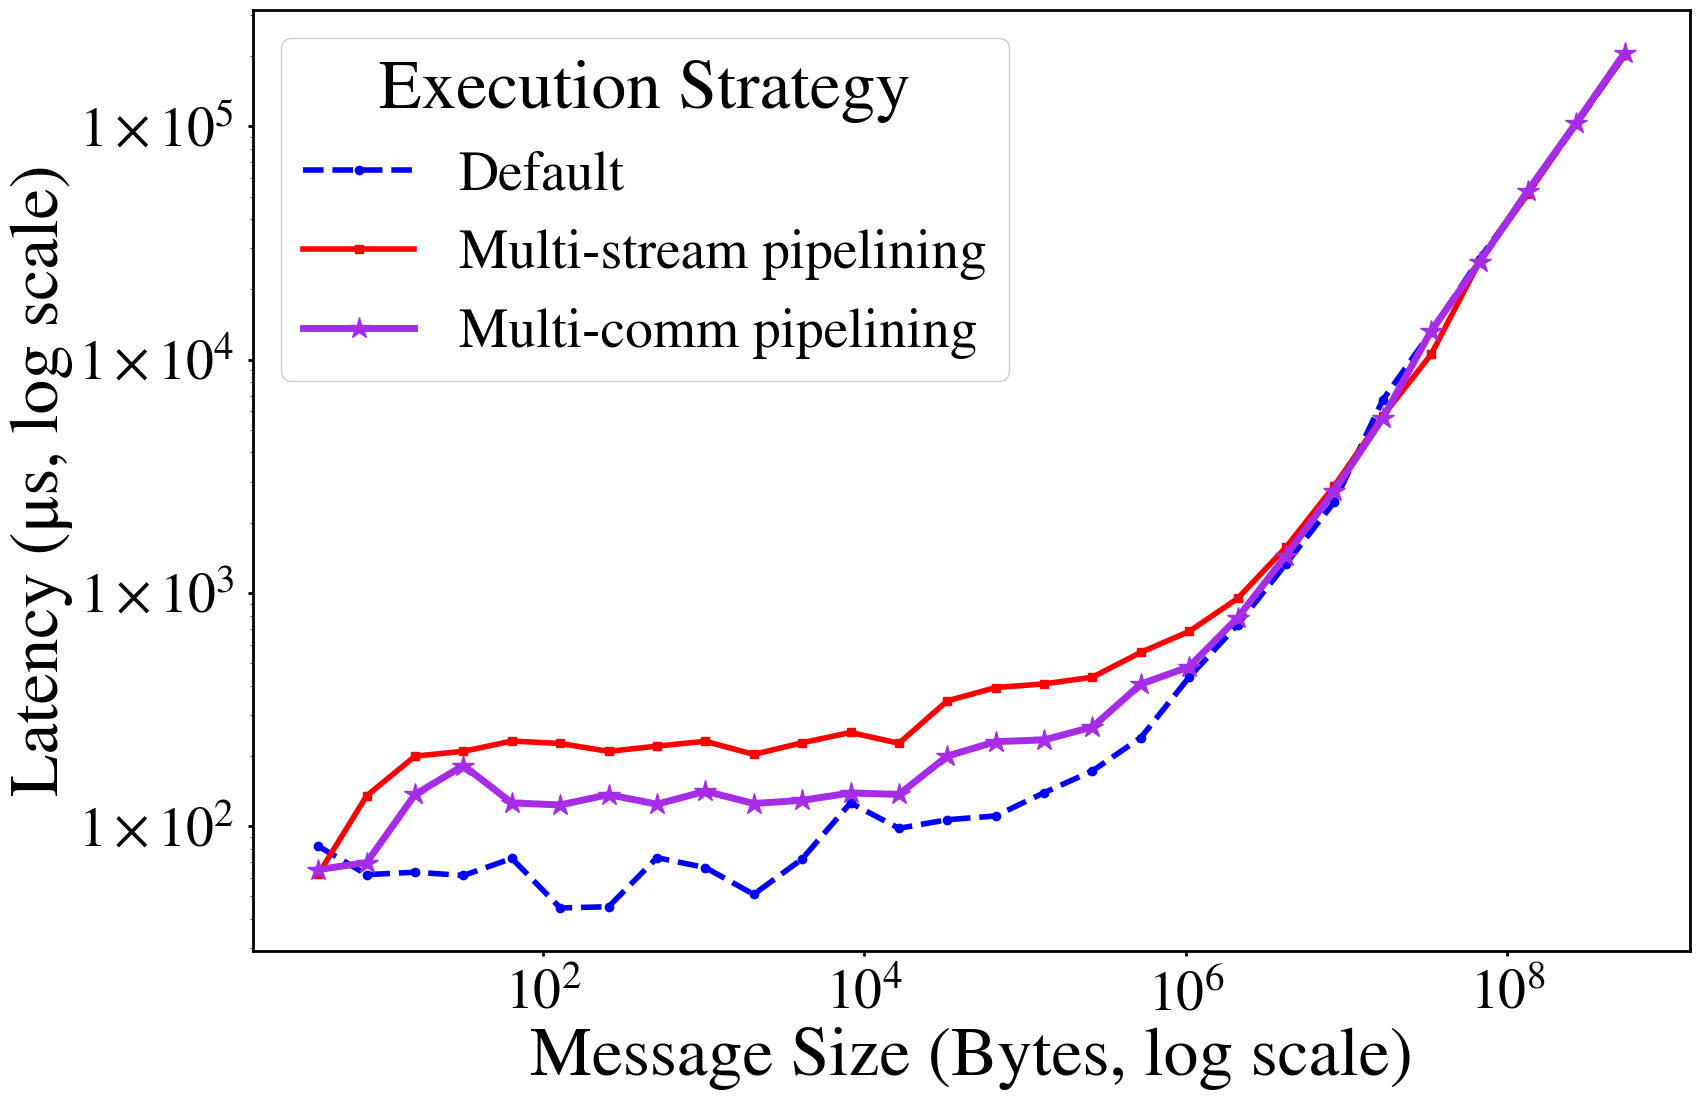

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
import matplotlib as mpl

# === Font config ===
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams.update({
    'font.size': 40,
    'axes.titlesize': 50,
    'axes.labelsize': 50,
    'legend.fontsize': 40,
    'legend.title_fontsize': 50,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40,
})

# === Load and merge data from multiple CSV files ===
files = {
    "Default": "og_beta.csv",
    "Multi-stream pipelining": "1comm4stream.csv",
    "Multi-communicator pipelining": "4comm4stream.csv",
    # "Pipelining": "pipelining.csv",  # Uncomment if available
}

all_data = []
for label, path in files.items():
    df = pd.read_csv(path)
    df['size'] = pd.to_numeric(df['size'], errors='coerce')
    df['latency'] = pd.to_numeric(df['latency'], errors='coerce')
    df = df.dropna(subset=['size', 'latency'])
    df = df[df['latency'] > 0]
    df['composition'] = label
    all_data.append(df)

df = pd.concat(all_data)
avg_df = df.groupby(['size', 'composition'])['latency'].mean().reset_index()
pivot_df = avg_df.pivot(index='size', columns='composition', values='latency')

# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(18, 12))
baseline = "Default"

ax1.tick_params(axis='both', colors='black', width=2, pad=10)
for spine in ax1.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# === Styles for each composition ===
styles = {
    "Default": dict(color="blue", marker='o', label="Default", linestyle='--', linewidth=4),
    "Pipelining": dict(color="orange", marker='^', label="Pipelining", linestyle='-', linewidth=4),
    "Multi-stream pipelining": dict(color="red", marker='s', label="Multi-stream pipelining", linestyle='-', linewidth=4),
    "Multi-communicator pipelining": dict(color="#a62ce8", marker='*', label="Multi-comm pipelining", linestyle='-', linewidth=5, markersize=16)
}

# === Latency curves ===
for comp, style in styles.items():
    if comp in pivot_df.columns:
        ax1.plot(pivot_df.index, pivot_df[comp], **style)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Message Size (Bytes, log scale)', color='black')
ax1.set_ylabel('Latency (μs, log scale)', color='black')


# === Scientific y-axis formatting ===
def sci_notation(x, _):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(x)))
    base = x / 10**exponent
    return rf"${int(base)} \times 10^{{{exponent}}}$"

ax1.yaxis.set_major_formatter(FuncFormatter(sci_notation))

# === Legend ===
handles1, labels1 = ax1.get_legend_handles_labels()
if 'ax2' in locals():
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles1 += handles2
    labels1 += labels2

ax1.legend(
    handles1, labels1,
    title="Execution Strategy",
    loc='upper left',
    facecolor="white", framealpha=1
)

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
if 'ax2' in locals():
    ax2.set_facecolor('white')

plt.tight_layout()
plt.savefig("pipelining.svg", facecolor='white')